In [67]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os 
import re
import pandas as pd
import scipy.stats as stats
path = '../saliency'
contents = os.listdir(path)

In [68]:
fNames  = contents[:]
for i in range(len(contents)): contents[i] = path + "/" +contents[i] 
att =  contents

scans = []
for i in att: 
    scans.append(np.load(i))

contents = os.listdir(path)

# Prepend the full path to each filename
file_paths = [os.path.join(path, filename) for filename in contents]

# Load each file and collect the filename and its data
scans = []
for file_path in file_paths:
    scan_data = np.load(file_path)
    scans.append({'filename': os.path.basename(file_path), 'scan_data': scan_data})

# Convert the list of dictionaries into a DataFrame
df_scans = pd.DataFrame(scans)

#print(df_scans.head())  # Display the first few rows of the DataFrame to verify the results
scan_data_only = df_scans['scan_data']
df_scans['stdyptid'] = df_scans['filename'].str.extract('(\d+)').astype(int)
df_excel =pd.read_csv('../data/subject_id_complete.csv') 
df_excel['stdyptid'] = df_excel['stdyptid'].str.extract('(\d+)').astype(int)

df = pd.merge(df_excel, df_scans, on='stdyptid', how='inner')
# Display the resulting DataFrame

In [90]:
# plot each plane
def plotScanArb(
        data, slice_indices,
        save_dir=None,          # one common folder, e.g. "plots/"
        fname="slices.png",     # will be overridden in the loop
        dpi=300
    ):
    volume = data.squeeze()
    xy, xz, yz = slice_indices

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    ax[0].imshow(volume[xy, :, :], cmap="viridis")
    ax[0].set_title(f"Slice {xy} (XY)"); ax[0].axis("off")

    ax[1].imshow(volume[:, xz, :], cmap="viridis")
    ax[1].set_title(f"Slice {xz} (XZ)"); ax[1].axis("off")

    ax[2].imshow(volume[:, :, yz], cmap="viridis")
    ax[2].set_title(f"Slice {yz} (YZ)"); ax[2].axis("off")

    plt.tight_layout()

    # Show the plot
    plt.tight_layout()
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)            # create once, harmless if repeated
        fig.savefig(os.path.join(save_dir, fname),
                    bbox_inches="tight", dpi=dpi)
        plt.close(fig)                                  # frees memory
    else:
        plt.show()

In [71]:
# 
def salSlice(attribution_data):
    attribution_3d = attribution_data.squeeze()

    # Compute the sum of absolute values for each slice in each plane
    sum_xz = np.sum(np.abs(attribution_3d), axis=0)  # Sum over X-axis, get XZ slices
    sum_xy = np.sum(np.abs(attribution_3d), axis=2)  # Sum over Z-axis, get XY slices
    sum_yz = np.sum(np.abs(attribution_3d), axis=1)  # Sum over Y-axis, get YZ slices

    # Find the indices of the most salient slice in each plane
    most_salient_xz = np.argmax(np.sum(sum_xz, axis=0))  # Most salient XZ slice
    most_salient_xy = np.argmax(np.sum(sum_xy, axis=0))  # Most salient XY slice
    most_salient_yz = np.argmax(np.sum(sum_yz, axis=0))  # Most salient YZ slice

    return [most_salient_xz, most_salient_xy, most_salient_yz]

In [73]:
scan_data_only = df['scan_data']
sal = np.array([salSlice(np.array(scan)) for scan in scan_data_only])

df["XZ"] = sal[:,0] 
df["XY"] = sal[:,1]
df["YZ"] = sal[:,2]

HC = df[df['Dx'] == 'HC']
BD = df[df['Dx'] != 'HC']

In [72]:
# There was no difference in the most salient slice across HC vs. BD
print(sal.shape) # sal is a two-dim array
print(stats.mode(sal[:,0])) # access  1st number from all the arrays
print(stats.mode(sal[:,1]) )# access  2nd number from all the arrays
print(stats.mode(sal[:,2])) # access  3rd number from all the arrays

(117, 3)
ModeResult(mode=array([32]), count=array([52]))
ModeResult(mode=array([49]), count=array([33]))
ModeResult(mode=array([32]), count=array([52]))


In [97]:
def extract_and_average(scan_data, idx, orientation):
    """
    Extracts slices based on the specified index and orientation from a list of 5D matrices and returns the averaged slice.

    Args:
        data_list (list of np.array): List containing 5D matrices to process.
        idx (int): The index to use for slicing the 5D matrices.
        orientation (str): Which plane to use for slicing ('xz', 'xy', or 'yz').

    Returns:
        np.array: Averaged slice across subjects based on the chosen orientation and index.
    """
    # Initialize lists to store slices
    selected_slices = []

    # Ensure the input data is squeezed correctly
    scan_data = [np.squeeze(matrix) for matrix in scan_data]

    # Loop through each 5D matrix in the column
    for matrix in scan_data:
        if orientation == 'yz':
            yz = matrix[idx, :, :]
          
            rotated_left = list(zip(*[reversed(row) for row in yz]))
            selected_slices.append(rotated_left)
            
            
        elif orientation == 'xz':
            xz = matrix [:,  idx, :]
            rotated_left = list(zip(*[reversed(row) for row in xz]))
            selected_slices.append(rotated_left)

        elif orientation == 'xy':
            # Extract the specified YZ slice
            xy = matrix[:, :, idx]
            xy = list(zip(*xy[::1]))
            selected_slices.append(xy)
        else:
            raise ValueError("Invalid orientation. Choose 'xz', 'xy', or 'yz'.")

    # Convert the list to a NumPy array and compute the mean across the first dimension
    selected_slices = np.array(selected_slices)

    averaged_slice= np.mean(selected_slices, axis=0)
    scaled_slice  = (averaged_slice - np.min(averaged_slice)) / (np.max(averaged_slice) - np.min(averaged_slice))

    return scaled_slice

In [99]:
# Apply the function to the column containing 5D matrices
BD_sagittal  = extract_and_average(BD['scan_data'], 32, 'yz')
BD_coronal  = extract_and_average(BD['scan_data'], 49, 'xz')
BD_axial  = extract_and_average(BD['scan_data'], 32, 'xy')


In [102]:
# Apply the function to the column containing 5D matrices
HC_sagittal  = extract_and_average(HC['scan_data'], 32, 'yz')
HC_coronal  = extract_and_average(HC['scan_data'], 49, 'xz')
HC_axial  = extract_and_average(HC['scan_data'], 32, 'xy')

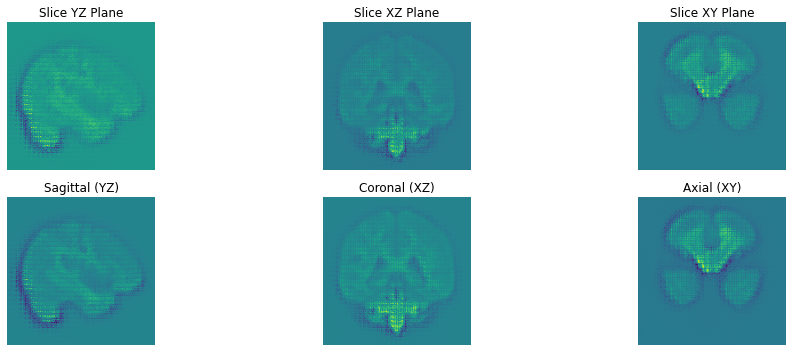

In [104]:

# First plot set for BD (2 rows x 3 columns)
fig1, ax1 = plt.subplots(2, 3, figsize=(15, 5))

# Adjust the first row of subplots for BD data
ax1[0, 0].imshow(BD_sagittal.squeeze(), cmap='viridis')
ax1[0, 0].set_title('Sagittal (YZ)')

ax1[0, 0].axis('off')

ax1[0, 1].imshow(BD_coronal.squeeze(), cmap='viridis')
ax1[0, 1].set_title('Coronal (XZ))
ax1[0, 1].axis('off')

ax1[0, 2].imshow(BD_axial.squeeze(), cmap='viridis')
ax1[0, 2].set_title('Slice XY Plane')
ax1[0, 2].axis('off')

# Adjust the second set of subplots for HC data
ax1[1, 0].imshow(HC_sagittal.squeeze(), cmap='viridis')
ax1[1,0].set_title('Sagittal (YZ)')
ax1[1,0].axis('off')

ax1[1,1].imshow(HC_coronal.squeeze(), cmap='viridis')
ax1[1,1].set_title('Coronal (XZ)')
ax1[1,1].axis('off')

ax1[1,2].imshow(HC_axial.squeeze(), cmap='viridis')
ax1[1,2].set_title('Axial (XY)')
ax1[1,2].axis('off')

# Adjust layout to ensure titles and plots are displayed properly
plt.tight_layout()

# Save the entire 2×3 grid to disk:
fig1.savefig("BD_vs_HC_most_salient_slices.png",
             dpi=300,            # adjust resolution as you like
             bbox_inches="tight" # trim any extra whitespace
)

plt.show()

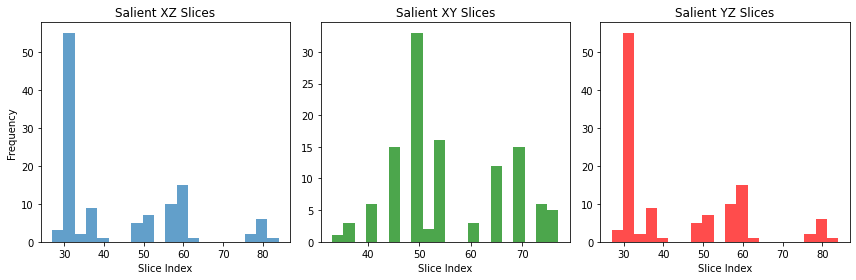

In [87]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(sal[:, 0], bins=20, alpha=0.7, label='XZ Plane')
plt.title('Salient XZ Slices')
plt.xlabel('Slice Index')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(sal[:, 1], bins=20, alpha=0.7, color='green', label='XY Plane')
plt.title('Salient XY Slices')
plt.xlabel('Slice Index')

plt.subplot(1, 3, 3)
plt.hist(sal[:, 2], bins=20, alpha=0.7, color='red', label='YZ Plane')
plt.title('Salient YZ Slices')
plt.xlabel('Slice Index')

plt.tight_layout()
plt.show()


### T-test comparing BD vs. HC saliency distributions across the slices

In [88]:
columns_to_test = ['XZ', 'XY', 'YZ']

# Dictionary to hold p-values
p_values = {}

# Perform t-test for each column
for column in columns_to_test:
    # Split data into two groups
    group_HC = df[df['Dx'] == 'HC'][column]
    group_BD = df[df['Dx'] == 'BD'][column]

    # Perform t-test
    t_stat, p_value = stats.ttest_ind(group_HC, group_BD, equal_var=False)  # Welch's t-test for unequal variances
    p_values[column] = p_value

# Output the results
print("P-values for each saliency column:")
for column, p_value in p_values.items():
    p_value = p_value /3
    print(f"{column}: {p_value:.4f}")

P-values for each saliency column:
XZ: 0.0451
XY: 0.0118
YZ: 0.0451


**BD PATIENTS**

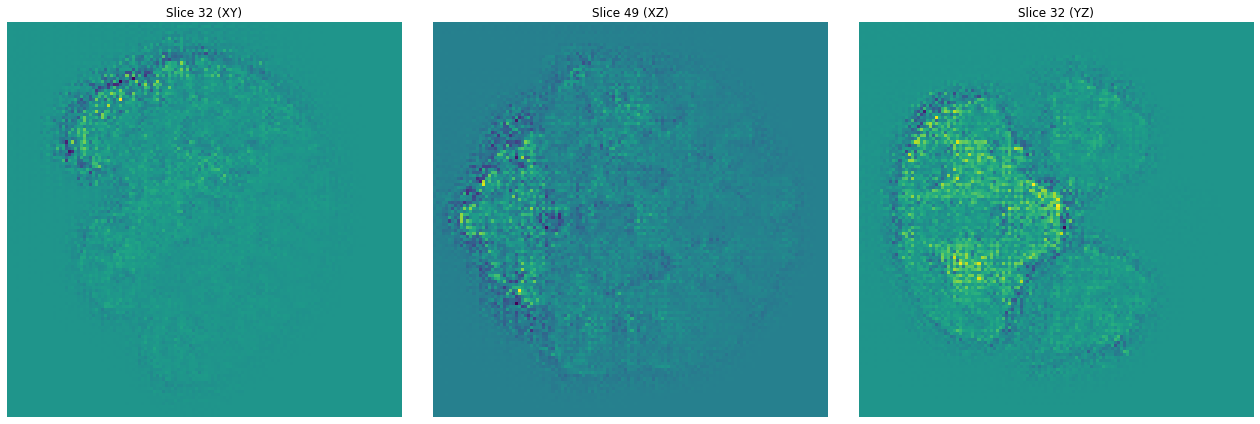

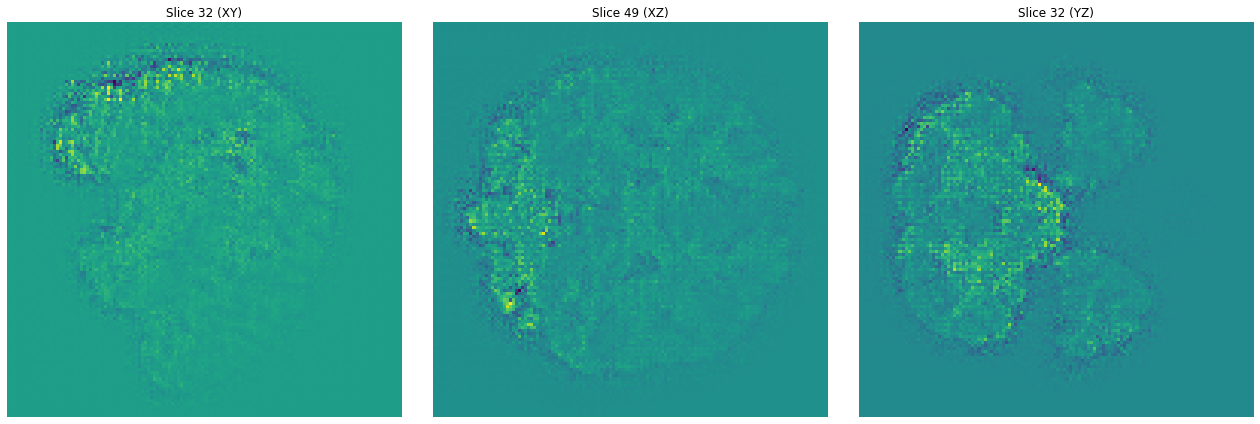

In [89]:
"""MOST SALIENT SLICES"""
base_out = "salient_slice_plots_bd"          # top-level folder for all subjects


for i, row in BD[:2].iterrows():
    subj_id = row["stdyptid"]          # replace with whatever identifies a subject
    slices  = [row[4], row[5], row[6]]   # xy, xz, yz indices
    volume  = row[3]                     # 3-D NumPy array

    # unique file name per subject
    file_name = f"sub-{subj_id:03d}_slices.png"

    plotScanArb(volume, slices,
               # save_dir=base_out,
                fname=file_name)



**HC GROUP**

In [ ]:
# """MOST SALIENT SLICES"""
# base_out = "salient_slice_plots_hc"          # top-level folder for all subjects


# for i, row in HC.iterrows():
#     subj_id = row["stdyptid"]          # replace with whatever identifies a subject
#     slices  = [row[4], row[5], row[6]]   # xy, xz, yz indices
#     volume  = row[3]                     # 3-D NumPy array

#     # unique file name per subject
#     file_name = f"sub-{subj_id:03d}_slices.png"

#     plotScanArb(volume, slices,
#                 save_dir=base_out,
#                 fname=file_name)



In [ ]:
# plotScanArb(scan_data_only[2], [1,1,1])

# # Example data creation
# data = scan_data_only[1]

# # Squeeze data to remove dimensions of size 1
# data = data.squeeze()

# # Create a figure for plotting
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # Normalize data for transparency mapping
# data_normalized = data / data.max()

# # Create a color mapping based on saliency
# colors = np.empty(data.shape, dtype=object)
# for i in range(data.shape[0]):
#     for j in range(data.shape[1]):
#         for k in range(data.shape[2]):
#             colors[i, j, k] = (1, 0, 0, data_normalized[i, j, k])  # Red color with variable alpha

# # Plotting the voxels
# ax.voxels(data > data.mean(), facecolors=colors, edgecolor='k')

# # Set labels and title if necessary
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ax.set_title('3D Saliency Map')

# # Show plot
# plt.show()